# A simple analytical example in 2 dimensions

This notebook accompanies the review article by Brumm, Krause, Schaab, & Scheidegger (2021) and corresponds to the example provided in section 2.4.

It intends to foster the basic intuition on how to use sparse grids as approximation method. In particular, we demonstrate their ability to efficiently interpolate the following d-dimensional (non-smooth) function: 


$$f_d(\vec{x}) = \max(0,1-e^{\frac{1}{2}-(\prod_{i=1}^d(x_i+\frac{1}{5}))^{\frac{1}{d}}}),\;\,\text{with}\,\vec{x}=\{x_1,\dots,x_d\}\in[0,1]^d.$$

Then, we generate a sparse grid as well as adaptive sparse grid approximations to the function and measure their accuracy as follows: We randomly generate 10,000 uniformly distributed test points, and compute the maximum error and the L1-error.

To do so, we use TASMANIAN library to showcase the general workflow of setting up a sparse grid and approximate a multivariate function. 

The adaptivity of grid points is implemented via the following choices:

- The command setSurplusRefinement(cutoffThreshold, outputUsed, typeRefinement) sets the refinement threshold, the model outputs that are considered in the refinment process as well as the type of refinement. For outputUsed, the default value is -1 implying that all outputs are used when refining. The options for typeRefinement are the following:

    ['classic', 'parents', 'direction', 'fds', 'stable'] (see TASMANIAN documentation for details) 

- The maximum refinement level in iteration i0 is determined by the grid level of the corresponding non-adaptive sparse grid, gridDepth[i0].

The notebook is organized as follows:

* Computation of errors for (non-adaptive) sparse grids from level 6 to 16.
* Computation of errors for adaptive sparse grids, starting from level 3 and allowing for refinement steps from level 6 to level 16.
* Visualization of grid points from a (non-adaptive) sparse grid of level 6 compared to the grid points from an adaptive sparse grid that is refined up to level 16.
* Visualization of the performance in steps 1. and 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy

import Tasmanian

# TeX Support for plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### 1. (NON-ADAPTIVE) SPARSE GRID with local basis functions  

Types of base functions for local sparse grids (see TASMANIAN documentation for more details)
['localp', 'semi-localp', 'localp-zero', 'localp-boundary']

In [2]:
# Number of dimensions
gridDim = 2
# Number of outputs
gridOut = 1
# Grid level (note that counting starts at 0; we vary the level from 6 to 16)
gridDepth = [5,6,7,8,9,10,11,12,13,14,15]
# 1=linear, 2=quadratic, 3=cubic
gridOrder = 1
# Type of base functions
gridRule = "localp"

# Domain of the grid (default for local grids is [-1,1]^n)
gridDomain = np.zeros((gridDim,2))
gridDomain[:,1] = 1.0

# Set random seed and number of draws
np.random.seed(seed=28092021)
TT = 10000

# Draw random numbers
evalPoints = np.random.rand(TT,gridDim)

# Number of distinct gridDepth values
noDepth = len(gridDepth)

# Preallocation of error arrays
l1ErrorNSG = np.zeros(noDepth)
l2ErrorNSG = np.zeros(noDepth)
lInfErrorNSG = np.zeros(noDepth)
# Array to store the resp. number of grid points
NSGPoints = np.zeros(noDepth,dtype=int)

# Index for grid_depth
i0 = 0

for ig in gridDepth:
    
    # Generate the grid structure
    gridNSG = Tasmanian.makeLocalPolynomialGrid(gridDim,gridOut,ig,gridOrder,gridRule)
    # Transform the domain
    gridNSG.setDomainTransform(gridDomain)
    # Get the points that require function values
    aPointsNSG = gridNSG.getNeededPoints()
    # Get the number of points
    aNumNSG = gridNSG.getNumPoints()
    # Store the number of points
    NSGPoints[i0] = aNumNSG

    # Preallocation of arrays
    fValuesNSG = np.empty((aNumNSG,gridOut))
    fTrueNSG = np.empty((TT,gridOut))
    fImpNSG = np.empty((TT,gridOut))

    # Compute the exact function values at the grid points
    for i1 in range(aNumNSG):

        fValuesNSG[i1] = np.maximum(0.0,1.0 - np.exp(0.5-np.prod(aPointsNSG[i1,:]+0.2)**(1.0/gridDim)))
    
    # Load function values into the grid structure
    gridNSG.loadNeededPoints(fValuesNSG)

    # Loop over random evaluation points
    for i2 in range(TT):

        # Compute the exact function values at the random evaluation points
        fTrueNSG[i2] = np.maximum(0.0,1.0 - np.exp(0.5-np.prod(evalPoints[i2,:]+0.2)**(1.0/gridDim)))
        # Interpolate the sparse grid at the random evaluation points
        fImpNSG[i2] = gridNSG.evaluate(evalPoints[i2,:])[0]
    
    # Compute the L1-error
    l1ErrorNSG[i0] = 1.0/TT*np.sum(np.abs(fTrueNSG-fImpNSG))
    # Compute the L2-error
    l2ErrorNSG[i0] = (1.0/TT*np.sum(np.abs(fTrueNSG-fImpNSG)**2))**0.5
    # Compute the LInf-error as the 99.9 percent quantile of the error distribution
    lInfErrorOrder = np.sort(np.abs(fTrueNSG-fImpNSG),axis=None)
    lInfErrorNSG[i0] = np.amax(lInfErrorOrder[:-10])
    
    # Store first sparse grid for scatter plots
    if (i0==0):
        aPointsNSG_plot = gridNSG.getPoints()
        fValuesNSG_plot = fValuesNSG
    

    i0 += 1

### 2. ADAPTIVE SPARSE GRID with local basis functions  

In [3]:
# Number of dimensions
gridDim = 2
# Number of outputs
gridOut = 1
# Grid level (we start with a sparse grid of level 3)
gridDepthASG = 2
# 1=linear, 2=quadratic, 3=cubic
gridOrder = 1
# Type of base functions
gridRule = "localp"

# Threshold for refinements
surplThreshold = 1e-6

# Preallocation of error arrays
l1ErrorNASG = np.zeros(noDepth)
l2ErrorNASG = np.zeros(noDepth)
lInfErrorNASG = np.zeros(noDepth)
# Array to store the resp. number of grid points
NASGPoints = np.zeros(noDepth,dtype=int)


for i0 in range(noDepth): 

    # Generate the grid structure
    gridNASG = Tasmanian.makeLocalPolynomialGrid(gridDim,gridOut,gridDepthASG,gridOrder,gridRule)
    # Transform the domain
    gridNASG.setDomainTransform(gridDomain)

    # Index of current grid level to control the number of refinements
    ilev = gridDepthASG

    while ((gridNASG.getNumNeeded() > 0) and (ilev<=gridDepth[i0])):

        # Get the points that require function values
        aPointsNASG = gridNASG.getNeededPoints()
        # Get the number of points that require function values
        aNumAdd = gridNASG.getNumNeeded()

        # Preallocation of function values array
        fValuesNASG = np.zeros((aNumAdd,gridOut))

        # Compute the exact function values at the grid points
        for i1 in range(aNumAdd):
            fValuesNASG[i1] = np.maximum(0.0,1.0 - np.exp(0.5-np.prod(aPointsNASG[i1,:]+0.2)**(1.0/gridDim)))
        
        # Load function values into the grid structure
        gridNASG.loadNeededPoints(fValuesNASG)
        
        # Refine the grid based on the surplus coefficients
        gridNASG.setSurplusRefinement(surplThreshold, -1, "classic")
        # Track the grid level
        ilev += 1
    
    # Store the number of grid points
    NASGPoints[i0] = gridNASG.getNumPoints()
    
    # Preallocation of arrays
    fTrueNASG = np.zeros(TT)
    fImpNASG = np.zeros(TT)

    # Loop over random evaluation points
    for i1 in range(TT):

        # Compute the exact function values at the random evaluation points
        fTrueNASG[i1] = np.maximum(0.0,1.0 - np.exp(0.5-np.prod(evalPoints[i1,:]+0.2)**(1.0/gridDim)))
        # Interpolate the adaptive sparse grid at the random evaluation points
        fImpNASG[i1] = gridNASG.evaluate(evalPoints[i1,:])[0]
    
    # Compute the L1-error
    l1ErrorNASG[i0] = 1.0/TT*np.sum(np.abs(fTrueNASG-fImpNASG))
    # Compute the L2-error
    l2ErrorNASG[i0] = (1.0/TT*np.sum(np.abs(fTrueNASG-fImpNASG)**2))**0.5
    # Compute the LInf-error as the 99.9 percent quantile of the error distribution
    lInfErrorOrder = np.sort(np.abs(fTrueNASG-fImpNASG),axis=None)
    lInfErrorNASG[i0] = np.amax(lInfErrorOrder[:-10])

### 3. Display sparse grid and adaptive sparse grid

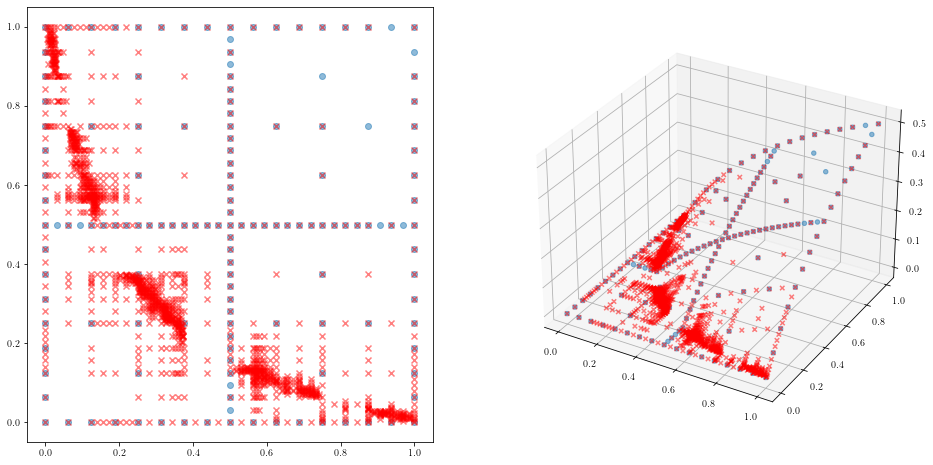

In [4]:
## Run the ASG again but with higher threshold

# New ASG surplus threshold
scatterThreshold = 1e-3

# Generate the grid structure as before
gridNASG_plot = Tasmanian.makeLocalPolynomialGrid(gridDim,gridOut,gridDepthASG,gridOrder,gridRule)
# Transform the domain
gridNASG_plot.setDomainTransform(gridDomain)

# Index of current grid level to control the number of refinements
ilev = gridDepthASG

while ((gridNASG_plot.getNumNeeded() > 0) and (ilev<=15)):
    
    # Get the points that require function values
    aPointsNASG_plot = gridNASG_plot.getNeededPoints()
    # Get the number of points that require function values
    aNumAdd = gridNASG_plot.getNumNeeded()

    # Preallocation of function values array
    fValuesNASG_plot = np.zeros((aNumAdd,gridOut))
    
    # Compute the exact function values at the grid points
    for i1 in range(aNumAdd):
        fValuesNASG_plot[i1] = np.maximum(0.0,\
                    1.0 - np.exp(0.5-np.prod(aPointsNASG_plot[i1,:]+0.2)**(1.0/gridDim)))
        
        
    # Load function values into the grid structure
    gridNASG_plot.loadNeededPoints(fValuesNASG_plot)
        
    # Refine the grid based on the surplus coefficients
    gridNASG_plot.setSurplusRefinement(scatterThreshold, -1, "classic")
    # Track the grid level
    ilev += 1


aPointsNASG_plot = gridNASG_plot.getPoints()
fValuesNASG_plot = gridNASG_plot.getLoadedValues()

fig = plt.figure(figsize=(16,8))
# First subplot
ax = fig.add_subplot(1,2,1)
ax.scatter(aPointsNSG_plot[:,0],aPointsNSG_plot[:,1],marker='o',alpha=0.5)
ax.scatter(aPointsNASG_plot[:,0],aPointsNASG_plot[:,1],marker='x',color='red',alpha=0.5)
# Second subplot
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(aPointsNSG_plot[:,0],aPointsNSG_plot[:,1],fValuesNSG_plot,marker='o',alpha=0.5)
ax.scatter(aPointsNASG_plot[:,0],aPointsNASG_plot[:,1],fValuesNASG_plot,\
           marker='x',color='red',alpha=0.5)

plt.savefig('GridPoints_SGvsASG.png', bbox_inches='tight')
plt.show()
plt.close()

### 4. Display performance

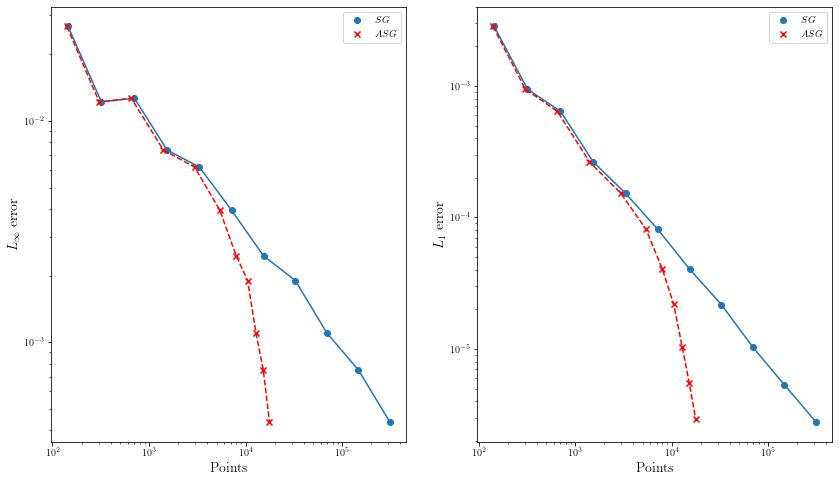

In [5]:
# Plot LInf-error and L1-error as function of the grid points

fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].scatter(NSGPoints,lInfErrorNSG, marker='o',label='$SG$')
ax[0].plot(NSGPoints,lInfErrorNSG)
ax[0].scatter(NASGPoints,lInfErrorNASG, marker = 'x', color='red', label='$ASG$')
ax[0].plot(NASGPoints,lInfErrorNASG,'--', color='red')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("Points", fontsize=14)
ax[0].set_ylabel("$L_{\infty}$ error", fontsize=14)
ax[0].legend()

ax[1].scatter(NSGPoints,l1ErrorNSG, marker='o',label='$SG$')
ax[1].plot(NSGPoints,l1ErrorNSG)
ax[1].scatter(NASGPoints,l1ErrorNASG, marker = 'x', color='red', label='$ASG$')
ax[1].plot(NASGPoints,l1ErrorNASG,'--', color='red')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("Points", fontsize=14)
ax[1].set_ylabel("$L_1$ error", fontsize=14)
ax[1].legend()

plt.savefig('AnalyticalExample_SGvsASG.png', bbox_inches='tight')
plt.show()
plt.close()

In [6]:
## Store the results in .txt files

# Error measures
NSGErrors = np.zeros((noDepth,3))
ASGErrors = np.zeros((noDepth,3))


for i1 in range(noDepth):
    NSGErrors[i1] = NSGPoints[i1],l1ErrorNSG[i1],lInfErrorNSG[i1]
    ASGErrors[i1] = NASGPoints[i1],l1ErrorNASG[i1],lInfErrorNASG[i1]
    
np.savetxt('resultsSparseGrids.txt', NSGErrors, header='Points, l1Error, lInfError')
np.savetxt('resultsAdaptiveSparseGrids.txt', ASGErrors, header='Points, l1Error, lInfError')

# Coordinates of grid points
np.savetxt('gridPointsSparseGrid.txt', aPointsNSG)
np.savetxt('gridPointsAdaptiveSparseGrid.txt', gridNASG.getPoints())